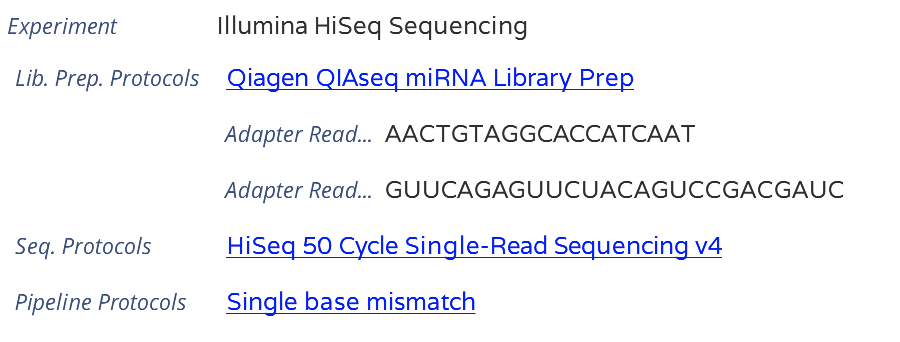

In [1]:
from IPython.display import Image
Image("miRNA-Seq Methods.png", width=500) 

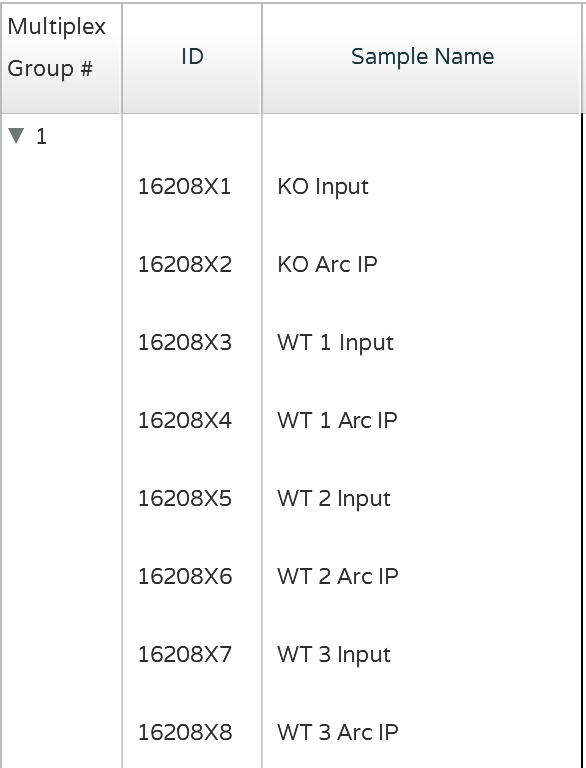

In [2]:
Image("Sample IDs.png", width=300) 

### Trimming task

In [27]:
%%bash
for f in fastq/*.fastq.gz; do
    out=${f/_R1_001.fastq.gz/.trim.fastq.gz};
    echo cutadapt -j 12 -q 15 -m 15 -a AACTGTAGGCACCATCAAT -o $out $f;
done

cutadapt -j 12 -q 15 -m 15 -a AACTGTAGGCACCATCAAT -o Fastq/16208X3_WT_1_Input.trim.fastq.gz Fastq/16208X3_WT_1_Input_R1_001.fastq.gz
cutadapt -j 12 -q 15 -m 15 -a AACTGTAGGCACCATCAAT -o Fastq/16208X3_WT_1_Input.trim.fastq.gz Fastq/16208X3_WT_1_Input.trim.fastq.gz
cutadapt -j 12 -q 15 -m 15 -a AACTGTAGGCACCATCAAT -o Fastq/16208X4_WT_1_Arc_IP.trim.fastq.gz Fastq/16208X4_WT_1_Arc_IP_R1_001.fastq.gz
cutadapt -j 12 -q 15 -m 15 -a AACTGTAGGCACCATCAAT -o Fastq/16208X4_WT_1_Arc_IP.trim.fastq.gz Fastq/16208X4_WT_1_Arc_IP.trim.fastq.gz


|**Summary** | |
|------|------|
| Total reads processed: | 28,192,485 |
| Reads with adapters: | 22,922,101 (81.3%) |
| Reads that were too short: | 4,348,263 (15.4%) |
| Reads written (passing filters): |  23,844,222 (84.6%) |
| Total basepairs processed: | 1,409,624,250 bp |
| Quality-trimmed: | 707,889 bp (0.1%) |
| Total written (filtered): | 759,775,723 bp (53.9%) |
| **Adapter 1** || 
| Sequence: | AACTGTAGGCACCATCAAT |
| Type: | regular 3'|
| Length: | 19| 
| Trimmed: | 22922101 times. |
|No. of allowed errors: 0-9 bp: 0; 10-19 bp: 1 | |
| **Bases preceding removed adapters:**||
| A: | 16.2% |
| C: | 18.1% |
| G: | 30.5% |
| T: | 35.2% |
| none/other: | 0.0% |


### Alignment task

In [ ]:
%%bash
for f in fastq/*.trim.fastq.gz; do
    out=${f/.trim.fastq.gz/.bam}   
    bowtie2 --sensitive --end-to-end -N 1 -p 12 -x /rumi/shams/genomes/mm10/mm10 -U $f | samtools view - -Sb  -h -t /rumi/shams/genomes/mm10/mm10.fa.fai -o $out

done&

#### 7971405 reads; of these:
- 7971405 (100.00%) were unpaired; of these:
- 3736669 (46.88%) aligned 0 times
- 1151104 (14.44%) aligned exactly 1 time
- 3083632 (38.68%) aligned >1 times
- 53.12% overall alignment rate

#### 23844222 reads; of these:
- 23844222 (100.00%) were unpaired; of these:
- 10959984 (45.96%) aligned 0 times
- 4318405 (18.11%) aligned exactly 1 time
- 8565833 (35.92%) aligned >1 times
- 54.04% overall alignment rate


#### Sorting _.bam_ files:

In [ ]:
%%bash 
for f in bam/*.bam; do
    out=${f/.bam/.srt.bam}
    samtools sort -@12 -o $out $f
done&

### Measure counts

In [ ]:
%%bash
for f in bam/*.srt.bam; do
    out=${f/.srt.bam/.gene.fc}
    featureCounts -T 12 -F SAF -P -B -C -O -a /rumi/shams/genomes/mm10/mm10_annotations/mm10_smRNA_miRNA_tRNA.saf -o $out $f;
done&

In [39]:
%%bash
less Fastq/16208X3_WT_1_Input.gene.fc.summary

Status	Fastq/16208X3_WT_1_Input.srt.bam
Assigned	418716
Unassigned_Unmapped	3736669
Unassigned_MappingQuality	0
Unassigned_Chimera	0
Unassigned_FragmentLength	0
Unassigned_Duplicate	0
Unassigned_MultiMapping	0
Unassigned_Secondary	0
Unassigned_Nonjunction	0
Unassigned_NoFeatures	3816020
Unassigned_Overlapping_Length	0
Unassigned_Ambiguity	0


In [40]:
%%bash
less Fastq/16208X4_WT_1_Arc_IP.gene.fc.summary

Status	Fastq/16208X4_WT_1_Arc_IP.srt.bam
Assigned	1169649
Unassigned_Unmapped	10959984
Unassigned_MappingQuality	0
Unassigned_Chimera	0
Unassigned_FragmentLength	0
Unassigned_Duplicate	0
Unassigned_MultiMapping	0
Unassigned_Secondary	0
Unassigned_Nonjunction	0
Unassigned_NoFeatures	11714589
Unassigned_Overlapping_Length	0
Unassigned_Ambiguity	0


### Load R

In [1]:
%load_ext rpy2.ipython

In [3]:
%%R
library(DESeq2, quietly = TRUE)
library(tidyverse, quietly = TRUE)
library(ggplot2, quietly = TRUE)
library(gridExtra, quietly = TRUE)
library(ggrepel, quietly = TRUE)
library(EnhancedVolcano, quietly = TRUE)
library(ggpubr, quietly = TRUE)

### Read data


In [42]:
%%R
files <- list.files(path = "Fastq", pattern="gene.fc$") 
cond <- c('WT_Input' , 'WT_Arc_IP')
datalist <- lapply(files, function(x){read.table(file=paste('Fastq/', x, sep = "") ,header=TRUE,colClasses=c(NA, "NULL", "NULL", "NULL", "NULL", "NULL", NA),check.names=F)})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
rownames(m) <- m[,1]
m <- m[,-1]
m[is.na(m)]<-0
m <- round(m)
f_name <- unlist(lapply(files, function(i) unlist(strsplit(i, "_"))[1]))
colnames(m) <- f_name
colData <- data.frame(cond, row.names=f_name)

# DE Analysis

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates



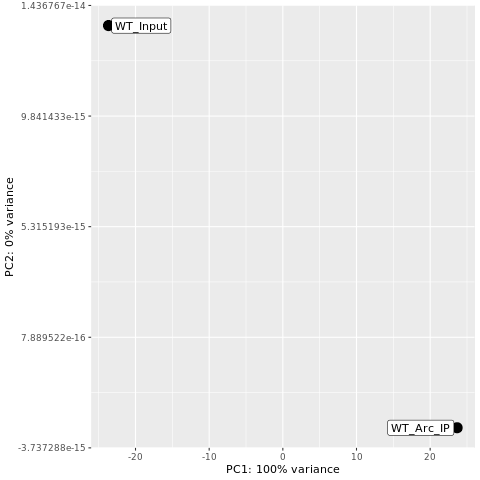

In [43]:
%%R
dds <- DESeqDataSetFromMatrix(countData = m, colData = colData, design = ~ cond)
dds$cond <- relevel(dds$cond, ref="WT_Input")
dds <- DESeq(dds)
cds <- estimateDispersions(dds)
vsd <- varianceStabilizingTransformation(cds)
# PCA Plot 
z <- plotPCA(vsd,intgroup=c("cond"), returnData=TRUE)
percentVar <- round(100 * attr(z, "percentVar"))
p <- ggplot(z, aes(PC1, PC2)) +
  geom_point(aes(size = 4)) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) +
  geom_label_repel(label = cond, force = 10) +
  labs(shape="Cell Lines", colour="Sample Type") +
  guides(size = FALSE)
print (p)

Model
$$WTArcIP - WTInput$$

In [44]:
%%R
# normalized counts 
ncu <- counts(dds, normalized=TRUE)
# Raw tabels 
write.table(ncu, file="Results/miRNA_gene_count_table_DE2norm.txt", sep="\t", quote=FALSE, col.names=cond) 
write.table(m, file="Results/miRNA_gene_count_table_raw.txt", sep="\t", quote=FALSE, col.names=cond )
# model:
res <- results(dds) # , contrast=list(c('cond_WT_Arc_IP_vs_WT_Input', 'cond_KO_Input_vs_WT_Input'),
#                                   c('cond_KO_Arc_IP_vs_WT_Input')), listValues=c(1,-1))
write.table(res, "Results/miRNA_WT_Arc_IP_VS_WT_Input.txt", sep="\t", quote=FALSE, col.names=NA)
# # Positive results 
res <- data.frame(res, row.names = rownames(res))
positive_res <- res %>% 
                rownames_to_column('gene') %>%
                filter(log2FoldChange > 0 & pvalue < 1e-1)
positive_ncu <- ncu[positive_res$gene,]
write.table(positive_res, file="Results/miRNA_positive_WT_Arc_IP_VS_WT_Input.txt", sep="\t", quote=FALSE, col.names=NA )
write.table(positive_ncu, file="Results/miRNA_positive_gene_count_table_DE2norm.txt", sep="\t", quote=FALSE, col.names=cond) 
resultsNames(dds)

[1] "Intercept"                  "cond_WT_Arc_IP_vs_WT_Input"


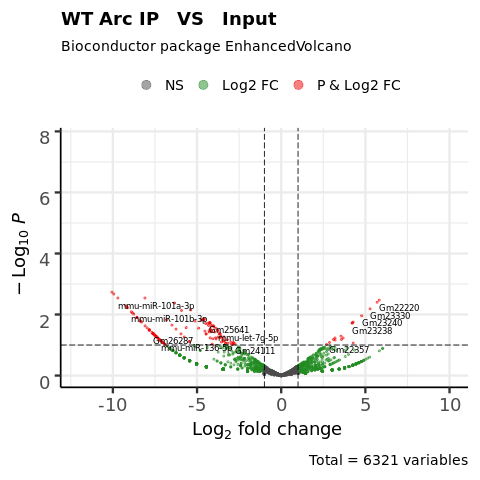

In [45]:
%%R
# Volcano plot 
vol <- EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'pvalue',
    xlim = c(-12, 10),
    title = 'WT Arc IP   VS   Input',
    pCutoff = 1e-1,
    FCcutoff = 1)
print (vol)

In [46]:
%%R
# check top genes 
top_genes <- rownames (positive_ncu)
myplots <- list() 
check <- data.frame()
for (g in 1:length(top_genes)){
    check <- rbind(check,data.frame(
        'Differential_Expression' = c(
            ncu[top_genes[g],rownames(subset (colData,cond == 'WT_Arc_IP'))],
            ncu[top_genes[g],rownames(subset (colData,cond == 'WT_Input'))]),
        'Conversion' = c('WT_Arc_IP','WT_Input'),
        'Gene' = top_genes[g]))
    rownames(check) <- c()
}

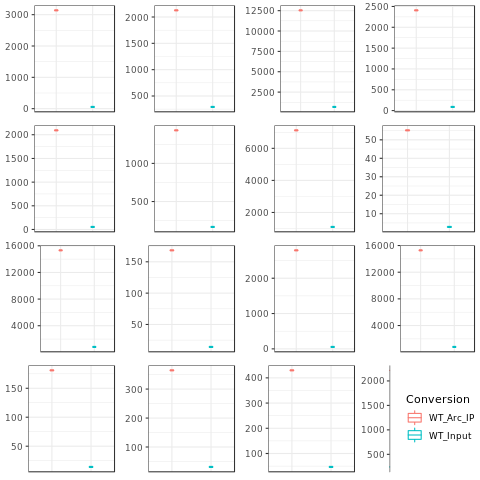

In [47]:
%%R 
# draw plots 
plist <- list()
pcntr <- 1
for (g in unique(check$Gene)){
    p <- ggplot(data = check %>% filter ( Gene == g ), 
                mapping = aes(x = Conversion, y = Differential_Expression, color = Conversion)) +
    geom_boxplot(width=0.1) +
    scale_fill_grey() 
    if (pcntr < length (unique(check$Gene))){
    p <- p +
        theme_bw() + 
        theme(axis.title.x=element_blank(), axis.text.x=element_blank(),
              axis.ticks.x=element_blank(), axis.title.y=element_blank(), legend.position="none")
    } else {
    p <- p +
        theme_bw() + 
        theme(axis.title.x=element_blank(), axis.text.x=element_blank(),
              axis.ticks.x=element_blank(), axis.title.y=element_blank(), legend.position = "right")
    }
    plist[[pcntr]] <- p
    pcntr <- pcntr + 1
}
do.call(grid.arrange, c(plist, ncol = 4))

In [48]:
%%R
dds <- estimateSizeFactors(dds)
data.frame('scale' = 1/sizeFactors(dds))

            scale
16208X3 1.4142136
16208X4 0.7071068


In [ ]:
%%bash
bedtools genomecov -bga -ibam bam/16208X3_WT_1_Input.srt.bam -scale 1.4142136 > bedgraph/16208X3_WT_1_Input.cov.bg&
bedtools genomecov -bga -ibam bam/16208X4_WT_1_Arc_IP.srt.bam -scale 0.7071068 > bedgraph/16208X4_WT_1_Arc_IP.cov.bg&


In [51]:
%%bash
# needed for IGV
for f in Fastq/16208X*srt.bam; do
    out=${f/.bam/.bam.bai}
    echo samtools index -@9 $f $out
done

samtools index -@9 Fastq/16208X3_WT_1_Input.srt.bam Fastq/16208X3_WT_1_Input.srt.bam.bai
samtools index -@9 Fastq/16208X4_WT_1_Arc_IP.srt.bam Fastq/16208X4_WT_1_Arc_IP.srt.bam.bai


In [55]:
ls -al Fastq/*.bai

-rw-r--r-- 1 abe users 4108648 Nov 15 00:19 Fastq/16208X3_WT_1_Input.srt.bam.bai
-rw-r--r-- 1 abe users 4568112 Nov 15 00:19 Fastq/16208X4_WT_1_Arc_IP.srt.bam.bai


In [68]:
%%R
library(Gviz, quietly = TRUE)
library(GenomicRanges, quietly = TRUE)
library(Rsamtools, quietly = TRUE)
library(tidyverse, quietly = TRUE)
library(TxDb.Mmusculus.UCSC.mm10.knownGene, quietly = TRUE)
library(rtracklayer, quietly = TRUE)
library(GenomicFeatures, quietly = TRUE)
# library(Sushi, quietly = TRUE)
library(data.table, quietly = TRUE)
library(dplyr, quietly = TRUE)
library(formattable, quietly = TRUE) 

In [74]:
%%R
### condition labels 
all_cond <- c('WT_Input' , 'WT_Arc_IP')
### cleaner function 
fc_cleaner <- function (fc){
    # chromosomes 
    tmp <- list()
    for (i in fc$Chr){tmp <- c(tmp,strsplit(i,';')[[1]][1])}
    fc$Chr <- unlist (tmp)
    # starts 
    tmp <- list()
    for (i in fc$Start){ tmp <- c(tmp,min(as.numeric(strsplit(i,';')[[1]])))}
    fc$Start <- as.numeric(unlist (tmp))
    # ends 
    tmp <- list()
    for (i in fc$End){ tmp <- c(tmp,max(as.numeric(strsplit(i,';')[[1]])))}
    fc$End <- as.numeric(unlist (tmp))
    # strands
    tmp <- list()
    for (i in fc$Strand){tmp <- c(tmp,strsplit(i,';')[[1]][1])}
    fc$Strand <- unlist (tmp)
    return (fc)
}
### load genomes
# mm10 ref genome
txdb <- TxDb.Mmusculus.UCSC.mm10.knownGene

# read all bedgraph files in R
bg_files <- list.files(path = 'bedgraph/', pattern="cov.bg$")
for (i in 1:length(bg_files)){
    assign(paste0("bedgraph_X", i), fread(paste('bedgraph/', bg_files[i],sep=''), col.names = c('chromosome', 'start', 'end', 'value'))
)}
### top genes 
files <- list.files(path = 'fc/', pattern="gene.fc$")
positive <- rownames(read.table(file="Results/miRNA_positive_gene_count_table_DE2norm.txt", sep="\t"))
top_genes <- lapply(files, function(x){read.table(file=paste('fc/', x, sep = ''),header=TRUE,colClasses=c(NA, NA, NA, NA, NA, NA,'NULL'),check.names=F, stringsAsFactors = F)})[[1]]
top_genes <- fc_cleaner(top_genes %>% filter ( Geneid %in% positive) )
### make top gene and gene stats dataframe:
tmp <- read.table(file="Results/miRNA_positive_WT_Arc_IP_VS_WT_Input.txt", sep="\t") [,-1]
colnames(tmp) <- droplevels(unlist (tmp[1,], use.names = FALSE))
tmp <- tmp[-1,]
rownames (tmp) <- tmp$gene
tmp <- tmp[top_genes$Geneid,] %>% dplyr::select (pvalue, log2FoldChange)
gene_stats <- data.frame (
    "Chr" = top_genes$Chr,
    "Strand" = top_genes$Strand,
    "Width" = top_genes$Length,
    "Start" = top_genes$Start,
    "End" = top_genes$End,                          
    "log2FoldChange" = round(as.numeric(as.character(tmp$log2FoldChange)), digits = 6), 
    "P-value" = scientific(as.numeric(as.character(tmp$pvalue)), digits = 3)
)
row.names(gene_stats) <- top_genes$Geneid
### plot generator function 
loci_plots <- function (cc, l_scale = 0, r_scale = 0, Z_out = 0, y_lim = NULL){
    ####
    print ("The top gene:")
    print (gene_stats[cc,] %>% dplyr::select(-Start, -End) )
    ####
    grtrack <- GeneRegionTrack(
        txdb, genome = 'mm10', 
        chromosome = as.character(gene_stats$Chr[cc]), name = "Gene Model",
        transcriptAnnotation = "symbol", showId=TRUE, geneSymbol=TRUE,
        background.panel = "#FFFEDB", background.title = "darkblue"
    )
    ####
    goverlap <- subsetByOverlaps(grtrack@range, GRanges(seqnames=gene_stats$Chr[cc], 
                                 ranges=IRanges(start = gene_stats$Start[cc], end = gene_stats$End[cc])))
    Transcript <- unique(subsetByOverlaps(grtrack@range, goverlap)$transcript)
    print ("mm10 overlap transcript:")
    print (Transcript)
    ####
    # final plot calling
    ots <- list()
    for (d in seq(1, by = 2, len = length(all_cond)/2)){
        #create data
        dtrack <- DataTrack(range = get(paste('bedgraph_X', d,sep='')), genome = "mm10",
                            from = gene_stats$Start[cc] - Z_out, to = gene_stats$End[cc] + Z_out,
                            chromosome = as.character(gene_stats$Chr[cc]))
        dtrack2<- DataTrack(range = get(paste('bedgraph_X', d + 1,sep='')), genome = "mm10",
                            from = gene_stats$Start[cc] - Z_out, to = gene_stats$End[cc] + Z_out,
                            chromosome = as.character(gene_stats$Chr[cc]),
                            groups = factor(all_cond[d+1],levels = c(all_cond[d],all_cond[d+1])))
        # Overlay IP and Input
        displayPars(dtrack) <- list(groups = factor(all_cond[d],levels = c(all_cond[d],all_cond[d+1]) ),
                                                    legend = TRUE)
        ots <- append (ots, OverlayTrack(trackList=list(dtrack2, dtrack)))
    }
    itrack <- IdeogramTrack(genome = 'mm10', chromosome = as.character(gene_stats$Chr[cc]))
    gtrack <- GenomeAxisTrack()
    plotTracks(append (list (itrack, gtrack), ots),
               from = gene_stats$Start[cc] - Z_out, to = gene_stats$End[cc] + Z_out,
               ylim = y_lim, type = "smooth")
    plotTracks(list (itrack, grtrack, gtrack),
               from = gene_stats$Start[cc], to = gene_stats$End[cc], main = "Transcripts",
               extend.left=l_scale, extend.right=r_scale)
}
# Genes for loci plot:
print (gene_stats %>% dplyr::select(-Start, -End) )

           Chr Strand Width log2FoldChange   P.value
Gm23240   chr1      -   121       4.779237 1.097e-02
Gm22357   chr1      +    83       2.868571 8.193e-02
Gm22220  chr12      +   149       5.830605 3.406e-03
Gm23502  chr14      +   145       3.103201 6.582e-02
Gm26117  chr15      +    95       5.698602 3.988e-03
Gm23737  chr15      +   159       4.285381 8.605e-02
Gm26244  chr18      -   164       4.277813 1.775e-02
Gm24924  chr18      -   164       4.231053 1.868e-02
Snora74a chr18      +   196       3.203532 6.870e-02
Gm49347  chr18      +   111       3.551792 5.129e-02
Gm23238  chr19      +   164       4.210513 1.914e-02
Gm25632   chr2      +    85       3.572884 6.592e-02
Gm26505   chr2      +   166       3.678066 5.848e-02
Gm23650   chr2      +    70       2.698299 9.498e-02
Gm23330   chr3      +   164       5.283932 6.460e-03
Snord107  chr7      -    70       3.196399 5.847e-02


[1] "The top gene:"
         Chr Strand Width log2FoldChange   P.value
Gm23240 chr1      -   121       4.779237 1.097e-02
[1] "mm10 overlap transcript:"
character(0)


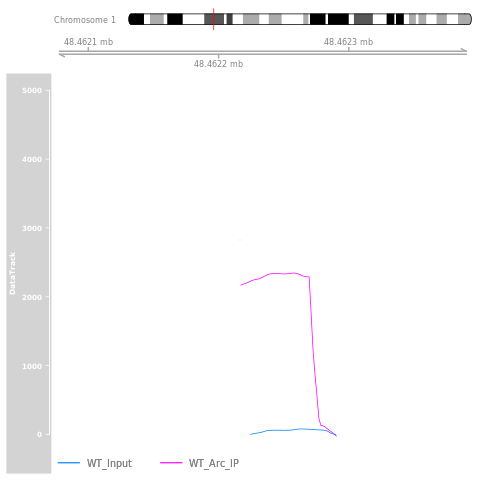

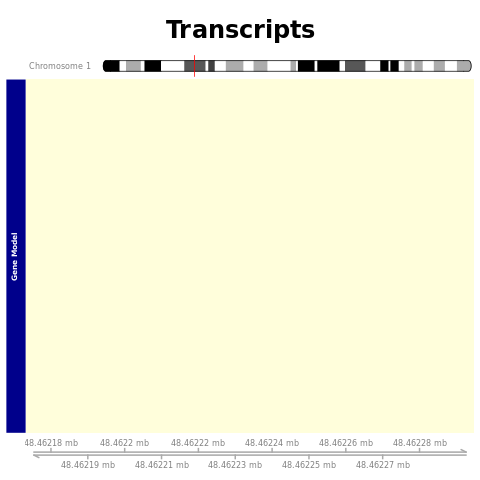

In [87]:
%%R
loci_plots (1, 0, 0, Z_out = 100,
            y_lim = c(0,5e3)) 

[1] "The top gene:"
         Chr Strand Width log2FoldChange   P.value
Gm22357 chr1      +    83       2.868571 8.193e-02
[1] "mm10 overlap transcript:"
[1] "uc007det.1" "uc007dev.1" "uc007dew.1" "uc011wun.1" "uc007deu.1"
[6] "uc007dex.1"


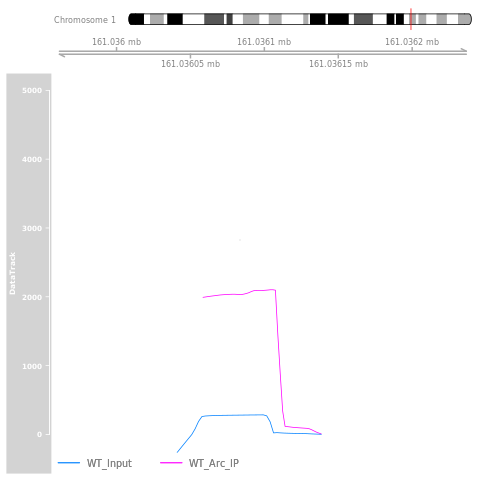

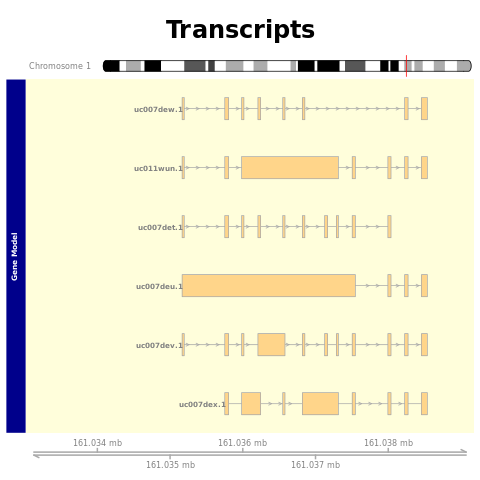

In [88]:
%%R
loci_plots (2, 3e3, 3e3, Z_out = 100,
            y_lim = c(0,5e3)) 

[1] "The top gene:"
          Chr Strand Width log2FoldChange   P.value
Gm22220 chr12      +   149       5.830605 3.406e-03
[1] "mm10 overlap transcript:"
character(0)


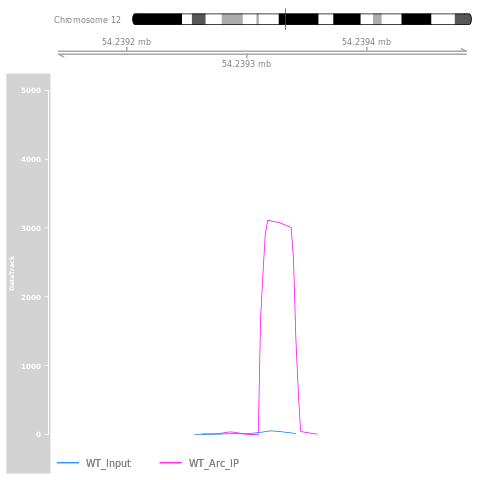

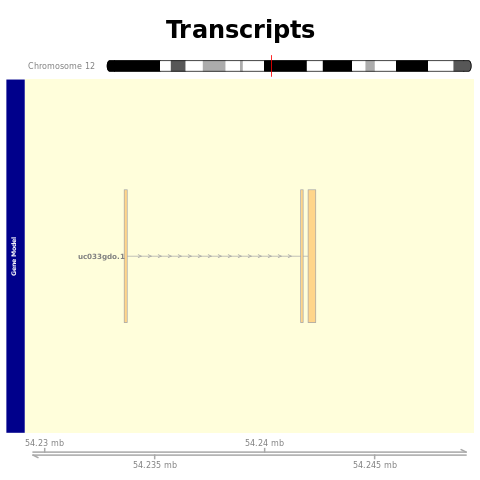

In [86]:
%%R
loci_plots (3, 1e4, 1e4, Z_out = 100,
            y_lim = c(0,5e3)) 

[1] "The top gene:"
          Chr Strand Width log2FoldChange   P.value
Gm23502 chr14      +   145       3.103201 6.582e-02
[1] "mm10 overlap transcript:"
character(0)


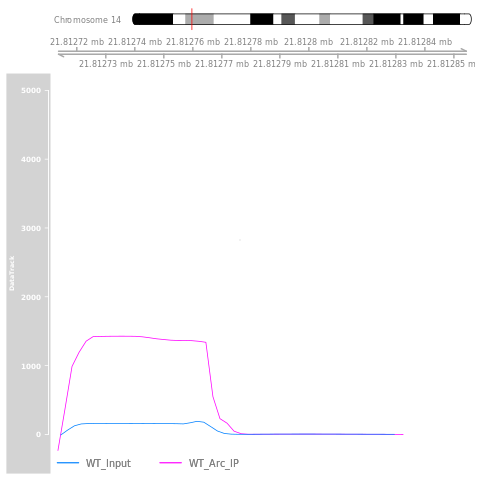

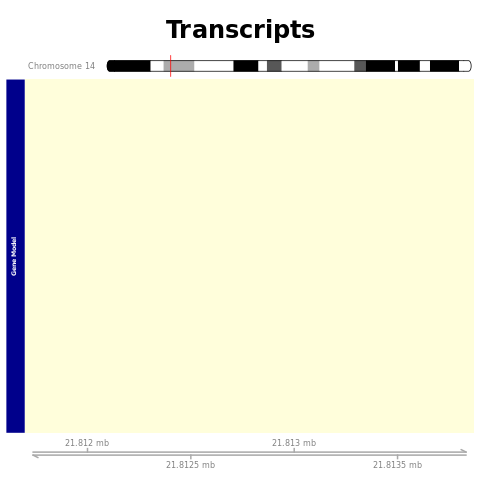

In [89]:
%%R
loci_plots (4, 1e3, 1e3, # Z_out = 100,
            y_lim = c(0,5e3)) 

[1] "The top gene:"
          Chr Strand Width log2FoldChange   P.value
Gm26117 chr15      +    95       5.698602 3.988e-03
[1] "mm10 overlap transcript:"
[1] "uc007wcr.1"


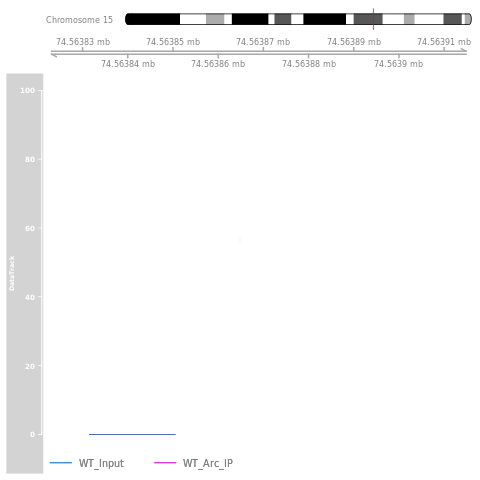

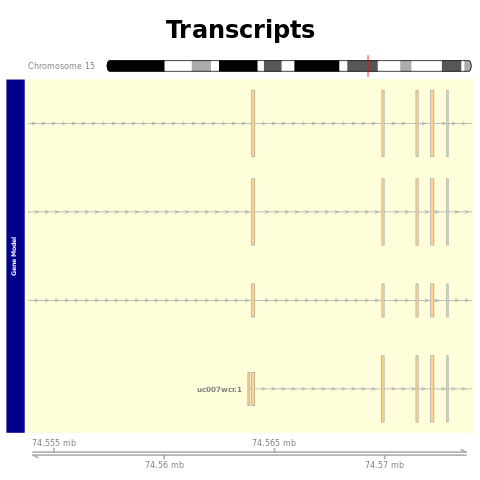

In [137]:
%%R
loci_plots (5, 1e4, 1e4, # Z_out = 100,
            y_lim = c(0,1e2)) 

In [99]:
%%R
loci_plots (6, 1e2, 1e2, # Z_out = 100,
            y_lim = c(0,5e3))

[1] "The top gene:"
          Chr Strand Width log2FoldChange   P.value
Gm23737 chr15      +   159       4.285381 8.605e-02
[1] "mm10 overlap transcript:"
character(0)


R[write to console]: Error in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE,  : 
  span is too small
Calls: <Anonymous> ... <Anonymous> -> panel.loess -> loess.smooth -> simpleLoess

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 




Error in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE,  : 
  span is too small
Calls: <Anonymous> ... <Anonymous> -> panel.loess -> loess.smooth -> simpleLoess


[1] "The top gene:"
          Chr Strand Width log2FoldChange   P.value
Gm26244 chr18      -   164       4.277813 1.775e-02
[1] "mm10 overlap transcript:"
character(0)


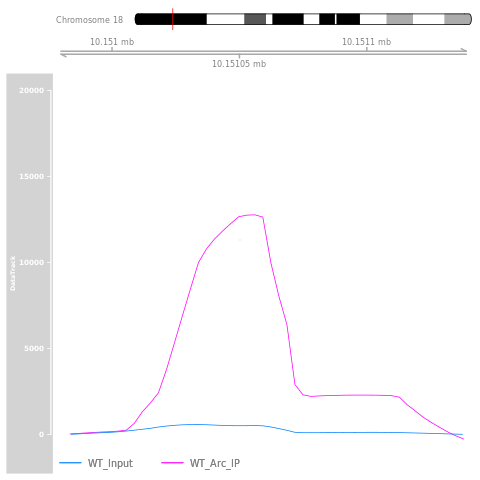

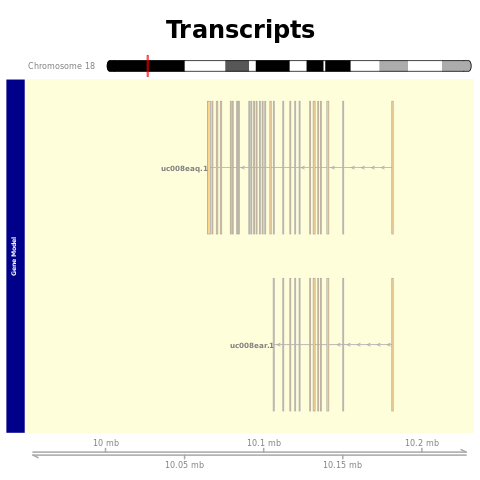

In [138]:
%%R
loci_plots (7, 2e5, 8e4, # Z_out = 100,
            y_lim = c(0,2e4)) 

[1] "The top gene:"
          Chr Strand Width log2FoldChange   P.value
Gm24924 chr18      -   164       4.231053 1.868e-02
[1] "mm10 overlap transcript:"
character(0)


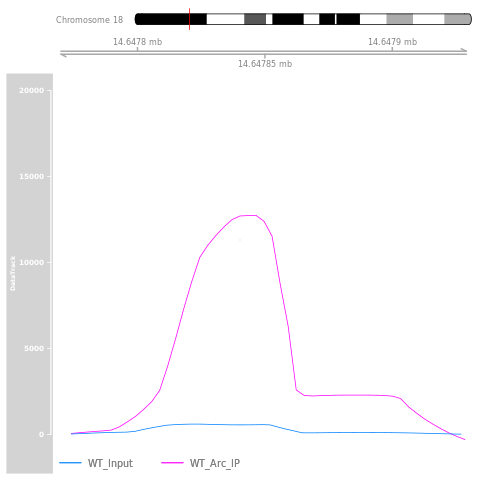

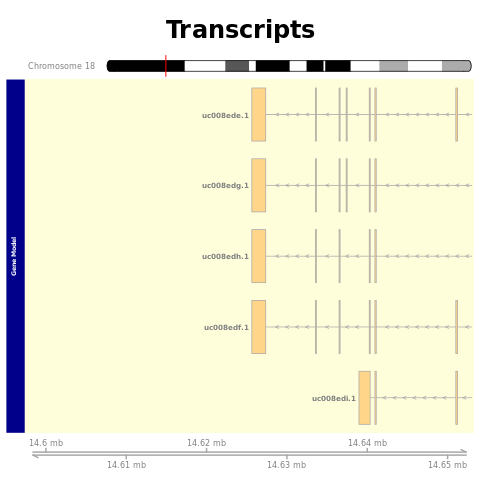

In [123]:
%%R
loci_plots (8, 5e4, 5e3, # Z_out = 100,
            y_lim = c(0,2e4)) 

[1] "The top gene:"
           Chr Strand Width log2FoldChange   P.value
Snora74a chr18      +   196       3.203532 6.870e-02
[1] "mm10 overlap transcript:"
[1] "uc008emf.1" "uc008eme.1" "uc012bbh.1"


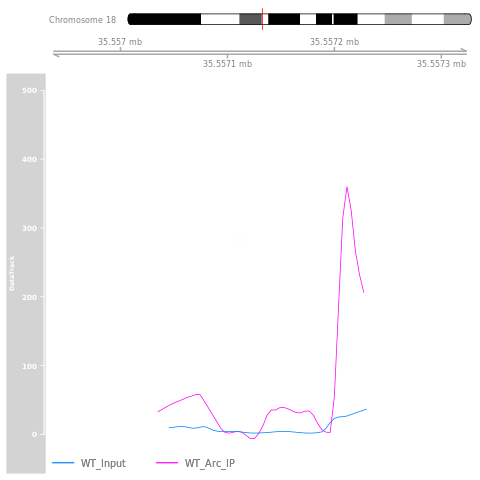

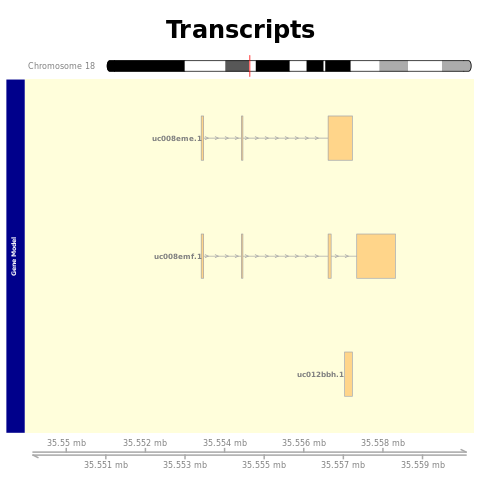

In [110]:
%%R
loci_plots (9, 8e3, 3e3, Z_out = 100,
            y_lim = c(0,5e2)) 

In [111]:
%%R
loci_plots (10, 6e4, 3e5, # Z_out = 100,
            y_lim = c(0,5e3)) 

[1] "The top gene:"
          Chr Strand Width log2FoldChange   P.value
Gm49347 chr18      +   111       3.551792 5.129e-02
[1] "mm10 overlap transcript:"
[1] "uc008emf.1" "uc008eme.1" "uc012bbh.1"


R[write to console]: Error in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE,  : 
  NA/NaN/Inf in foreign function call (arg 1)
Calls: <Anonymous> ... <Anonymous> -> panel.loess -> loess.smooth -> simpleLoess

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 




Error in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE,  : 
  NA/NaN/Inf in foreign function call (arg 1)
Calls: <Anonymous> ... <Anonymous> -> panel.loess -> loess.smooth -> simpleLoess


[1] "The top gene:"
          Chr Strand Width log2FoldChange   P.value
Gm23238 chr19      +   164       4.210513 1.914e-02
[1] "mm10 overlap transcript:"
character(0)


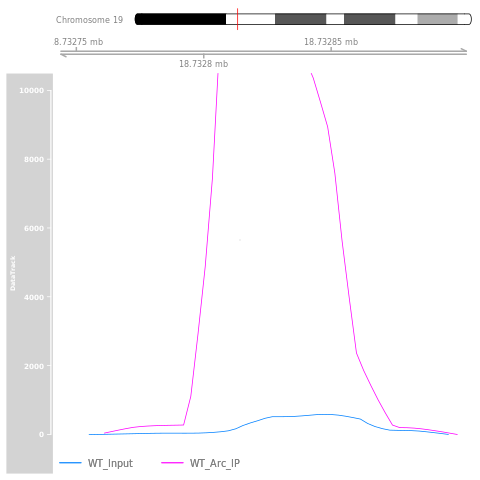

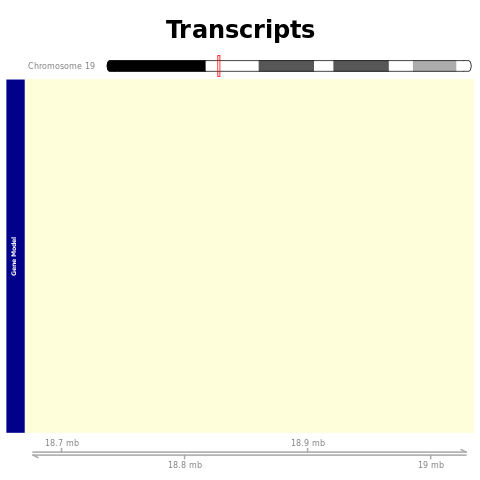

In [140]:
%%R
loci_plots (11, 6e4, 3e5, # Z_out = 100,
            y_lim = c(0,1e4))

In [118]:
%%R
loci_plots (12, 6e4, 3e5, # Z_out = 100,
            y_lim = c(0,5e3)) 

[1] "The top gene:"
         Chr Strand Width log2FoldChange   P.value
Gm25632 chr2      +    85       3.572884 6.592e-02
[1] "mm10 overlap transcript:"
character(0)


R[write to console]: Error in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE,  : 
  NA/NaN/Inf in foreign function call (arg 1)
Calls: <Anonymous> ... <Anonymous> -> panel.loess -> loess.smooth -> simpleLoess

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 




Error in simpleLoess(y, x, w, span, degree = degree, parametric = FALSE,  : 
  NA/NaN/Inf in foreign function call (arg 1)
Calls: <Anonymous> ... <Anonymous> -> panel.loess -> loess.smooth -> simpleLoess


[1] "The top gene:"
         Chr Strand Width log2FoldChange   P.value
Gm26505 chr2      +   166       3.678066 5.848e-02
[1] "mm10 overlap transcript:"
[1] "uc008lpj.1"


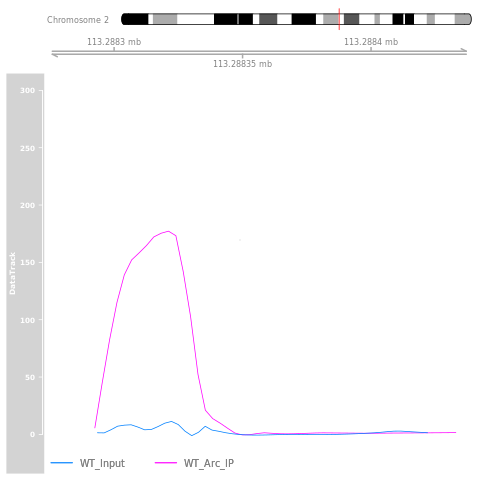

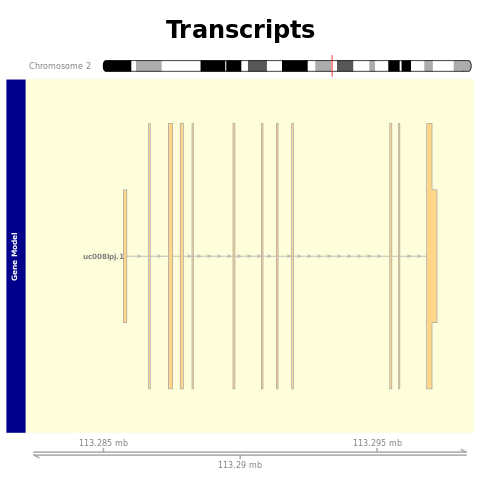

In [141]:
%%R
loci_plots (13, 6e3, 1e4, # Z_out = 100,
            y_lim = c(0,3e2)) 

[1] "The top gene:"
         Chr Strand Width log2FoldChange   P.value
Gm23650 chr2      +    70       2.698299 9.498e-02
[1] "mm10 overlap transcript:"
character(0)


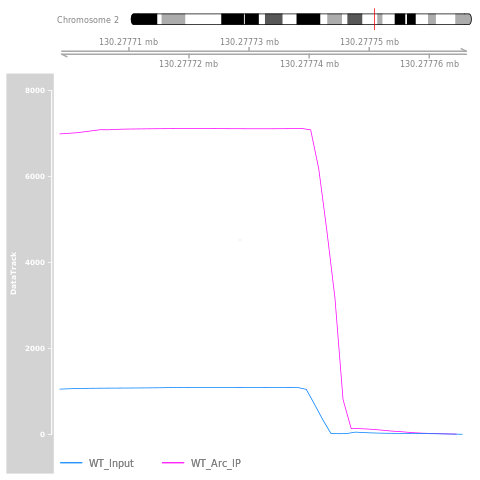

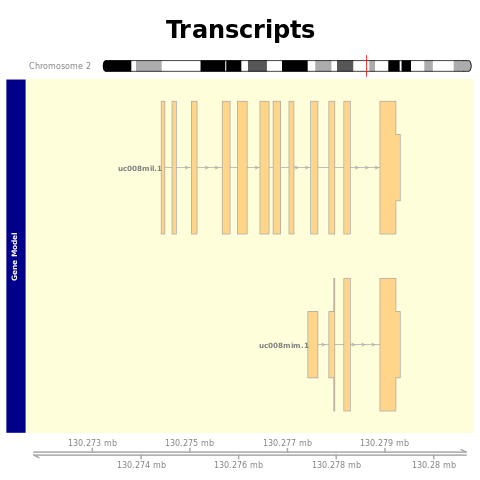

In [132]:
%%R
loci_plots (14, 6e3, 3e3, # Z_out = 100,
            y_lim = c(0,8e3)) 

[1] "The top gene:"
         Chr Strand Width log2FoldChange   P.value
Gm23330 chr3      +   164       5.283932 6.460e-03
[1] "mm10 overlap transcript:"
character(0)


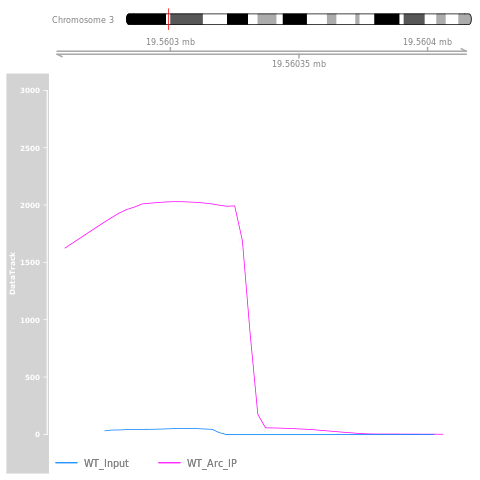

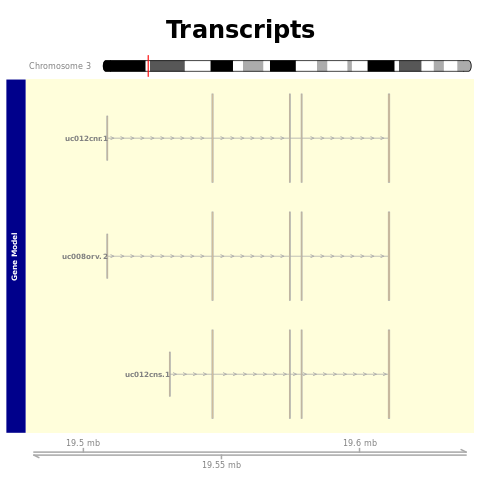

In [142]:
%%R
loci_plots (15, 8e4, 8e4, # Z_out = 100,
            y_lim = c(0,3e3)) 

[1] "The top gene:"
          Chr Strand Width log2FoldChange   P.value
Snord107 chr7      -    70       3.196399 5.847e-02
[1] "mm10 overlap transcript:"
character(0)


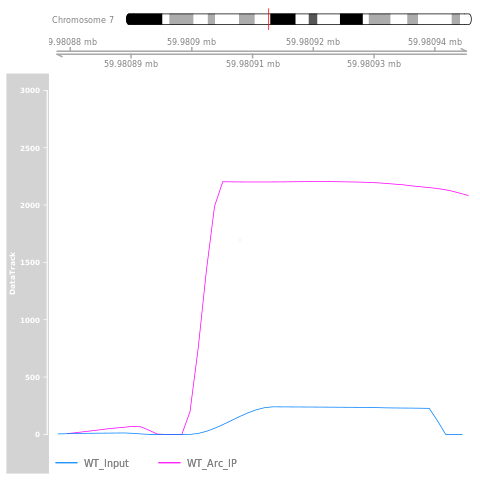

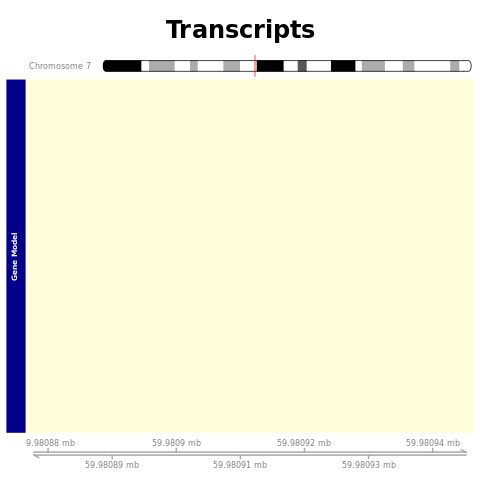

In [128]:
%%R
loci_plots (16, 0, 0, # Z_out = 100,
            y_lim = c(0,3e3)) 

# Systemic analysis 

Merge .bam files:

In [ ]:
%%bash
samtools merge -@ 12 fastq/all.merged.bam fastq/*srt.bam
# sort the merged file 
samtools sort -@12 fastq/all.merged.bam > fastq/all.merged.srt.bam
# bam to bet
bedtools bamtobed -i fastq/all.merged.srt.bam > all.merged.srt.bed

In [ ]:
%%bash
###### Systematic ######
Piranha -s -b 500 all.merged.srt.bed -o all.merged.piranha.txt &

In [19]:
ls *piranha.txt

all.merged.piranha.txt


In [ ]:
%%bash
cat *.piranha.txt | sort -k1,1 -k2,2n -k3,3n | mergeBed -s -d 0 -c 6 -o distinct -i stdin | awk '{printf("%s\t%d\t%d\tdsRNA_tag_%d\t1\t%s\n",$1,$2,$3, NR,$4)}' > dsRNA_piranha.bed
awk '{printf("%s\t%s\t%d\t%d\t%s\n",$4,$1,$2+1,$3,$6)}' dsRNA_piranha.bed > dsRNA_piranha.saf

In [21]:
%%bash
featureCounts -T 12 -O -F SAF -a dsRNA_piranha.saf -o 16208X3_WT_1_Input.piranha.fc fastq/16208X3_WT_1_Input.srt.bam
featureCounts -T 12 -O -F SAF -a dsRNA_piranha.saf -o 16208X4_WT_1_Arc_IP.piranha.fc fastq/16208X4_WT_1_Arc_IP.srt.bam


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v1.6.0

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 1 BAM file                                       ||
||                           S Fastq/16208X3_WT_1_Input.srt.bam               ||
||                                                                            ||
||             Output file : 16208X3_WT_1_Input.piranha.fc                    ||
||                 Summary : 16208X3_WT_1_Input.piranha.fc.summar

In [4]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [5]:
%%R
library(DESeq2, quietly = TRUE)
library(tidyverse, quietly = TRUE)
library(ggplot2, quietly = TRUE)
library(gridExtra, quietly = TRUE)
library(ggrepel, quietly = TRUE)
library(EnhancedVolcano, quietly = TRUE)
library(ggpubr, quietly = TRUE)

### Read data


In [160]:
%%R
files <- list.files(path = 'piranha', pattern=".piranha.fc$")

cond <- c('WT_Input' , 'WT_Arc_IP')
datalist <- lapply(files, function(x){read.table(file=paste('piranha/', x, sep = ""),header=TRUE,colClasses=c(NA, "NULL", "NULL", "NULL", "NULL", "NULL", NA),check.names=F)})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
f_name <- unlist(lapply(files, function(i) unlist(strsplit(i, "_"))[1]))
rownames(m) <- m[,1]
m <- m[,-1]
m[is.na(m)]<-0
m <- round(m)
f_name <- unlist(lapply(files, function(i) unlist(strsplit(i, "_"))[1]))
colnames(m) <- f_name
colData <- data.frame(cond, row.names=f_name)
head(m)

               16208X3 16208X4
dsRNA_tag_1         53     137
dsRNA_tag_10        38     232
dsRNA_tag_100       49     236
dsRNA_tag_1000      79     136
dsRNA_tag_1001     158     464
dsRNA_tag_1002      90     323


# DE Analysis

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='lo

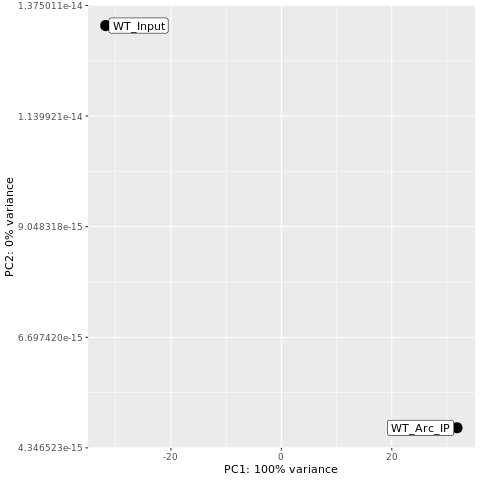

In [161]:
%%R
dds <- DESeqDataSetFromMatrix(countData = m, colData = colData, design = ~ cond)
dds$cond <- relevel(dds$cond, ref="WT_Input")
dds <- DESeq(dds)
cds <- estimateDispersions(dds)
vsd <- varianceStabilizingTransformation(cds)
# PCA Plot 
z <- plotPCA(vsd,intgroup=c("cond"), returnData=TRUE)
percentVar <- round(100 * attr(z, "percentVar"))
p <- ggplot(z, aes(PC1, PC2)) +
  geom_point(aes(size = 4)) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) +
  geom_label_repel(label = cond, force = 10) +
  labs(shape="Cell Lines", colour="Sample Type") +
  guides(size = FALSE)
print (p)

Model
$$WTArcIP - WTInput$$

In [162]:
%%R
# normalized counts 
ncu <- counts(dds, normalized=TRUE)
# Raw tabels 
write.table(ncu, file="Results/piranha_miRNA_gene_count_table_DE2norm.txt", sep="\t", quote=FALSE, col.names=cond) 
write.table(m, file="Results/piranha_miRNA_gene_count_table_raw.txt", sep="\t", quote=FALSE, col.names=cond )
# model:
res <- results(dds) # , contrast=list(c('cond_WT_Arc_IP_vs_WT_Input', 'cond_KO_Input_vs_WT_Input'),
#                                   c('cond_KO_Arc_IP_vs_WT_Input')), listValues=c(1,-1))
write.table(res, "Results/piranha_miRNA_WT_Arc_IP_VS_WT_Input.txt", sep="\t", quote=FALSE, col.names=NA)
# # Positive results 
res <- data.frame(res, row.names = rownames(res))
positive_res <- res %>% 
                rownames_to_column('gene') %>%
                filter(log2FoldChange > 0 & pvalue < 1e-1)
positive_ncu <- ncu[positive_res$gene,]
write.table(positive_res, file="Results/piranha_miRNA_positive_WT_Arc_IP_VS_WT_Input.txt", sep="\t", quote=FALSE, col.names=NA )
write.table(positive_ncu, file="Results/piranha_miRNA_positive_gene_count_table_DE2norm.txt", sep="\t", quote=FALSE, col.names=cond) 
resultsNames(dds)

[1] "Intercept"                  "cond_WT_Arc_IP_vs_WT_Input"


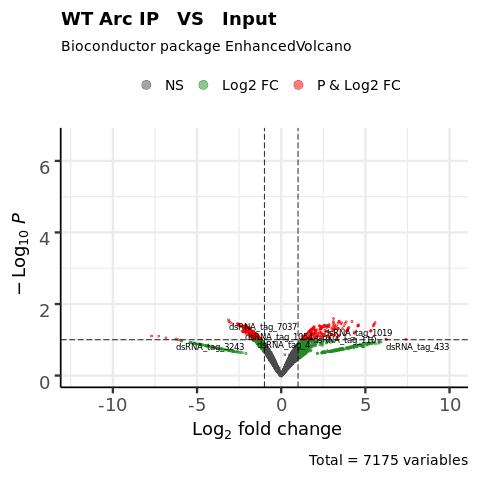

In [163]:
%%R
# Volcano plot 
vol <- EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'pvalue',
    xlim = c(-12, 10),
    title = 'WT Arc IP   VS   Input',
    pCutoff = 1e-1,
    FCcutoff = 1)
print (vol)

In [164]:
%%R
# check top genes 
top_genes <- rownames (positive_ncu)
myplots <- list() 
check <- data.frame()
for (g in 1:length(top_genes)){
    check <- rbind(check,data.frame(
        'Differential_Expression' = c(
            ncu[top_genes[g],rownames(subset (colData,cond == 'WT_Arc_IP'))],
            ncu[top_genes[g],rownames(subset (colData,cond == 'WT_Input'))]),
        'Conversion' = c('WT_Arc_IP','WT_Input'),
        'Gene' = top_genes[g]))
    rownames(check) <- c()
}

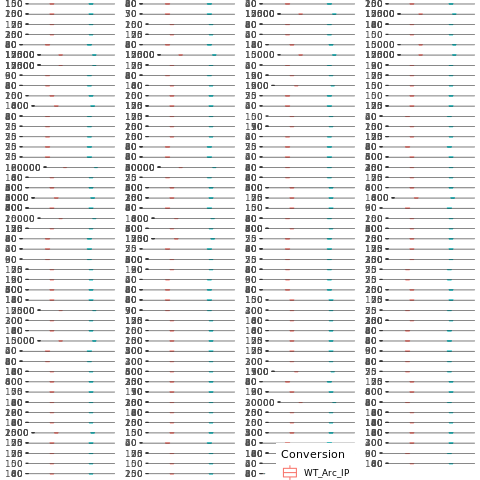

In [165]:
%%R 
# draw plots 
plist <- list()
pcntr <- 1
for (g in unique(check$Gene)){
    p <- ggplot(data = check %>% filter ( Gene == g ), 
                mapping = aes(x = Conversion, y = Differential_Expression, color = Conversion)) +
    geom_boxplot(width=0.1) +
    scale_fill_grey() 
    if (pcntr < length (unique(check$Gene))){
    p <- p +
        theme_bw() + 
        theme(axis.title.x=element_blank(), axis.text.x=element_blank(),
              axis.ticks.x=element_blank(), axis.title.y=element_blank(), legend.position="none")
    } else {
    p <- p +
        theme_bw() + 
        theme(axis.title.x=element_blank(), axis.text.x=element_blank(),
              axis.ticks.x=element_blank(), axis.title.y=element_blank(), legend.position = "right")
    }
    plist[[pcntr]] <- p
    pcntr <- pcntr + 1
}
do.call(grid.arrange, c(plist, ncol = 4))

In [29]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [36]:
%%R
library(Gviz, quietly = TRUE)
library(GenomicRanges, quietly = TRUE)
library(Rsamtools, quietly = TRUE)
library(tidyverse, quietly = TRUE)
library(TxDb.Mmusculus.UCSC.mm10.knownGene, quietly = TRUE)
library(rtracklayer, quietly = TRUE)
library(GenomicFeatures, quietly = TRUE)
# library(Sushi, quietly = TRUE)
library(data.table, quietly = TRUE)
library(dplyr, quietly = TRUE)

In [177]:
# %%R
# ### condition labels 
# all_cond <- c('WT_Input' , 'WT_Arc_IP')
# ### load genomes
# # mm10 ref genome
# txdb <- TxDb.Mmusculus.UCSC.mm10.knownGene

# # read all bedgraph files in R
# bg_files <- list.files(path = 'bedgraph/', pattern="cov.bg$")
# for (i in 1:length(bg_files)){
#     assign(paste0("bedgraph_X", i), fread(paste('bedgraph/', bg_files[i],sep=''), col.names = c('chromosome', 'start', 'end', 'value'))
# )}
# ### top genes 
# files <- list.files(path = 'piranha/', pattern="piranha.fc$")
# positive <- rownames(read.table(file="Results/piranha_miRNA_positive_gene_count_table_DE2norm.txt", sep="\t"))
# top_genes <- lapply(files, function(x){read.table(
#     file=paste('piranha/', x, sep = ''),header=TRUE,
#     colClasses=c(NA, NA, NA, NA, NA, NA,'NULL'),
#     check.names=F, stringsAsFactors = F)})[[1]]
# top_genes <- fc_cleaner(top_genes %>% filter ( Geneid %in% positive) )
# ## make top gene and gene stats dataframe:
# tmp <- read.table(file="Results/piranha_miRNA_positive_WT_Arc_IP_VS_WT_Input.txt", sep="\t") [,-1]
# colnames(tmp) <- droplevels(unlist (tmp[1,], use.names = FALSE))
# tmp <- tmp[-1,]
# rownames (tmp) <- tmp$gene
# tmp <- tmp[top_genes$Geneid,] %>% dplyr::select (pvalue, log2FoldChange)
# gene_stats <- data.frame (
#     "Chr" = top_genes$Chr,
#     "Strand" = top_genes$Strand,
#     "Width" = top_genes$Length,
#     "Start" = top_genes$Start,
#     "End" = top_genes$End,                          
#     "log2FoldChange" = round(as.numeric(as.character(tmp$log2FoldChange)), digits = 6), 
#     "P-value" = scientific(as.numeric(as.character(tmp$pvalue)), digits = 3)
# )
# row.names(gene_stats) <- top_genes$Geneid
# ### plot generator function 
# loci_plots <- function (cc, l_scale = 0, r_scale = 0, Z_out = 0, y_lim = NULL){
#     ####
#     print ("The top gene:")
#     print (gene_stats[cc,] %>% dplyr::select(-Start, -End) )
#     ####
#     grtrack <- GeneRegionTrack(
#         txdb, genome = 'mm10', 
#         chromosome = as.character(gene_stats$Chr[cc]), name = "Gene Model",
#         transcriptAnnotation = "symbol", showId=TRUE, geneSymbol=TRUE,
#         background.panel = "#FFFEDB", background.title = "darkblue"
#     )
#     ####
#     goverlap <- subsetByOverlaps(grtrack@range, GRanges(seqnames=gene_stats$Chr[cc], 
#                                  ranges=IRanges(start = gene_stats$Start[cc], end = gene_stats$End[cc])))
#     Transcript <- unique(subsetByOverlaps(grtrack@range, goverlap)$transcript)
#     print ("mm10 overlap transcript:")
#     print (Transcript)
#     ####
#     # final plot calling
#     ots <- list()
#     for (d in seq(1, by = 2, len = length(all_cond)/2)){
#         #create data
#         dtrack <- DataTrack(range = get(paste('bedgraph_X', d,sep='')), genome = "mm10",
#                             from = gene_stats$Start[cc] - Z_out, to = gene_stats$End[cc] + Z_out,
#                             chromosome = as.character(gene_stats$Chr[cc]))
#         dtrack2<- DataTrack(range = get(paste('bedgraph_X', d + 1,sep='')), genome = "mm10",
#                             from = gene_stats$Start[cc] - Z_out, to = gene_stats$End[cc] + Z_out,
#                             chromosome = as.character(gene_stats$Chr[cc]),
#                             groups = factor(all_cond[d+1],levels = c(all_cond[d],all_cond[d+1])))
#         # Overlay IP and Input
#         displayPars(dtrack) <- list(groups = factor(all_cond[d],levels = c(all_cond[d],all_cond[d+1]) ),
#                                                     legend = TRUE)
#         ots <- append (ots, OverlayTrack(trackList=list(dtrack2, dtrack)))
#     }
#     itrack <- IdeogramTrack(genome = 'mm10', chromosome = as.character(gene_stats$Chr[cc]))
#     gtrack <- GenomeAxisTrack()
#     plotTracks(append (list (itrack, gtrack), ots), main = 'Piranha', 
#                from = gene_stats$Start[cc] - Z_out, to = gene_stats$End[cc] + Z_out,
#                ylim = y_lim, type = "smooth")
#     plotTracks(list (itrack, grtrack, gtrack),
#                from = gene_stats$Start[cc], to = gene_stats$End[cc], main = "Transcripts",
#                extend.left=l_scale, extend.right=r_scale)
# }
# # Genes for loci plot:
# print (gene_stats %>% dplyr::select(-Start, -End) )

In [181]:
%%R
# top_genes <- fc_cleaner(top_genes %>% filter ( Geneid %in% positive) )
positive

  [1] "dsRNA_tag_1019" "dsRNA_tag_1025" "dsRNA_tag_1052" "dsRNA_tag_1057"
  [5] "dsRNA_tag_110"  "dsRNA_tag_111"  "dsRNA_tag_1157" "dsRNA_tag_1158"
  [9] "dsRNA_tag_1179" "dsRNA_tag_1276" "dsRNA_tag_128"  "dsRNA_tag_1294"
 [13] "dsRNA_tag_13"   "dsRNA_tag_1300" "dsRNA_tag_1311" "dsRNA_tag_1312"
 [17] "dsRNA_tag_1363" "dsRNA_tag_1369" "dsRNA_tag_1416" "dsRNA_tag_1417"
 [21] "dsRNA_tag_1418" "dsRNA_tag_1419" "dsRNA_tag_1420" "dsRNA_tag_1421"
 [25] "dsRNA_tag_1423" "dsRNA_tag_1449" "dsRNA_tag_1513" "dsRNA_tag_1526"
 [29] "dsRNA_tag_1550" "dsRNA_tag_1616" "dsRNA_tag_1772" "dsRNA_tag_1795"
 [33] "dsRNA_tag_1840" "dsRNA_tag_1869" "dsRNA_tag_191"  "dsRNA_tag_196" 
 [37] "dsRNA_tag_1981" "dsRNA_tag_2070" "dsRNA_tag_2092" "dsRNA_tag_2103"
 [41] "dsRNA_tag_228"  "dsRNA_tag_2306" "dsRNA_tag_2436" "dsRNA_tag_2463"
 [45] "dsRNA_tag_2701" "dsRNA_tag_2729" "dsRNA_tag_274"  "dsRNA_tag_2742"
 [49] "dsRNA_tag_2743" "dsRNA_tag_2860" "dsRNA_tag_289"  "dsRNA_tag_2904"
 [53] "dsRNA_tag_3092" "dsRNA_tag_3166

In [ ]:
all_loci_plots (3, 150, 80, Z_out = 100, y_lim = c(0,1400))